# Convolutional Neural Networks (LeNet)
:label:`sec_lenet`

We now have all the ingredients required to assemble
a fully-functional CNN.
In our earlier encounter with image data, we applied
a linear model with softmax regression (:numref:`sec_softmax_scratch`)
and an MLP (:numref:`sec_mlp-implementation`)
to pictures of clothing in the Fashion-MNIST dataset.
To make such data amenable we first flattened each image from a $28\times28$ matrix
into a fixed-length $784$-dimensional vector,
and thereafter processed them in fully connected layers.
Now that we have a handle on convolutional layers,
we can retain the spatial structure in our images.
As an additional benefit of replacing fully connected layers with convolutional layers,
we will enjoy more parsimonious models that require far fewer parameters.

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun,
then a researcher at AT&T Bell Labs,
for the purpose of recognizing handwritten digits in images :cite:`LeCun.Bottou.Bengio.ea.1998`.
This work represented the culmination
of a decade of research developing the technology;
LeCun's team published the first study to successfully
train CNNs via backpropagation :cite:`LeCun.Boser.Denker.ea.1989`.

At the time LeNet achieved outstanding results
matching the performance of support vector machines,
then a dominant approach in supervised learning, achieving an error rate of less than 1% per digit.
LeNet was eventually adapted to recognize digits
for processing deposits in ATM machines.
To this day, some ATMs still run the code
that Yann LeCun and his colleague Leon Bottou wrote in the 1990s!


In [ ]:
# Colab-compatible d2l minimal replacement
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class DataModule:
    def save_hyperparameters(self): pass
    def get_dataloader(self, train): raise NotImplementedError

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
    def save_hyperparameters(self): pass
    def forward(self, X): return self.net(X)
    def apply_init(self, inputs, init_fn):
        with torch.no_grad(): self.net(*inputs)
        self.net.apply(init_fn)
        return self

class Trainer:
    def __init__(self, max_epochs=10, num_gpus=0):
        self.max_epochs = max_epochs
        self.num_gpus = num_gpus
        self.show_progress = False
    def fit(self, model, data): print("Use custom training loop")

class ProgressBoard:
    def __init__(self):
        self.x, self.xlabel = 'epoch', 'epoch'
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.data = {}
    def draw(self, x, y, label):
        if label not in self.data: self.data[label] = {'x': [], 'y': []}
        self.data[label]['x'].append(x)
        self.data[label]['y'].append(y)
        self.ax.clear()
        for lbl, vals in self.data.items():
            self.ax.plot(vals['x'], vals['y'], label=lbl, marker='o')
        self.ax.set_xlabel(self.xlabel)
        self.ax.legend()
        self.ax.grid(True)
        plt.tight_layout()

def try_gpu(i=0):
    return torch.device(f'cuda:{i}' if torch.cuda.is_available() else 'cpu')

def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
        return obj
    return wrapper

# Create a module-like object
class d2l_module:
    DataModule = DataModule
    Classifier = Classifier
    Trainer = Trainer
    ProgressBoard = ProgressBoard
    try_gpu = staticmethod(try_gpu)
    add_to_class = staticmethod(add_to_class)

d2l = d2l_module()

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [ ]:

class CIFAR10Data(d2l.DataModule):  #@save
    """Minimal CIFAR-10 DataModule compatible with d2l.Trainer."""
    def __init__(self, batch_size=128, num_workers=4, root="../data", aug=True):
        super().__init__()
        self.save_hyperparameters()
        normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        if aug:
            self.train_tfms = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            self.train_tfms = transforms.Compose([transforms.ToTensor(), normalize])
        self.test_tfms = transforms.Compose([transforms.ToTensor(), normalize])
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train = datasets.CIFAR10(root=root, train=True, download=True, transform=self.train_tfms)
        self.val = datasets.CIFAR10(root=root, train=False, download=True, transform=self.test_tfms)

    def get_dataloader(self, train):
        ds = self.train if train else self.val
        return DataLoader(ds, batch_size=self.batch_size, shuffle=train, num_workers=self.num_workers, pin_memory=True)


In [ ]:

class MNISTData(d2l.DataModule):  #@save
    """Minimal MNIST DataModule compatible with d2l.Trainer."""
    def __init__(self, batch_size=128, num_workers=4, root="../data", aug=True):
        super().__init__()
        self.save_hyperparameters()
        mnist_mean, mnist_std = 0.1307, 0.3081
        normalize = transforms.Normalize((mnist_mean,), (mnist_std,))
        if aug:
            self.train_tfms = transforms.Compose([
                transforms.Resize(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            self.train_tfms = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize])
        self.test_tfms = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), normalize])
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train = datasets.MNIST(root=root, train=True, download=True, transform=self.train_tfms)
        self.val = datasets.MNIST(root=root, train=False, download=True, transform=self.test_tfms)

    def get_dataloader(self, train):
        ds = self.train if train else self.val
        return DataLoader(ds, batch_size=self.batch_size, shuffle=train, num_workers=self.num_workers, pin_memory=True)


In [ ]:
import torch
from torch import nn

class LazyConv2d_scratch(nn.Module):  # @save
    """Conv2d from scratch with lazy in_channels. No torch.nn.functional usage.
    Supports groups, stride, padding, dilation, bias."""
    def __init__(self, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        kernel_size = (kernel_size, kernel_size)
        stride      = (stride, stride)
        padding     = (padding, padding)
        dilation    = (dilation, dilation)
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.stride       = stride
        self.padding      = padding
        self.dilation     = dilation
        self.groups       = groups
        self.bias_flag    = bias
        self.weight = None
        self.bias   = None
        self._initialized = False

    def _init_params(self, in_channels: int, device=None, dtype=None):
        assert in_channels % self.groups == 0, "in_channels must be divisible by groups"
        kh, kw = self.kernel_size
        w = torch.empty(self.out_channels, in_channels // self.groups, kh, kw, device=device, dtype=dtype)
        nn.init.xavier_uniform_(w)
        self.weight = nn.Parameter(w)
        if self.bias_flag:
            self.bias = nn.Parameter(torch.zeros(self.out_channels, device=device, dtype=dtype))
        self._initialized = True

    @staticmethod
    def _pad2d(x, pad_h, pad_w):
        if pad_h == 0 and pad_w == 0:
            return x
        N, C, H, W = x.shape
        out = x.new_zeros((N, C, H + 2*pad_h, W + 2*pad_w))
        out[:, :, pad_h:pad_h+H, pad_w:pad_w+W] = x
        return out

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # IMPLEMENTATION ROADMAP (fill each TODO with code):

        # Lazy init
        if not self._initialized:
            self._init_params(x.shape[1], device=x.device, dtype=x.dtype)

        #1 TODO  Parse shapes / hyperparams
        # Extract N, C, H, W from x.shape.
        # Unpack (kh, kw), (sh, sw), (ph, pw), (dh, dw) from self.
        # Let g = self.groups; compute c_per_g = C // g; o_per_g = self.out_channels // g.
        # Add assertions:
        #    * C % g == 0
        #   * self.out_channels % g == 0
        N, C, H, W = x.shape
        kh, kw = self.kernel_size
        sh, sw = self.stride
        ph, pw = self.padding
        dh, dw = self.dilation

        g = self.groups
        c_per_g = C // g
        o_per_g = self.out_channels // g

        assert C % g == 0, f"Input channels ({C}) must be divisible by groups ({g})"
        assert self.out_channels % g == 0, f"Output channels ({self.out_channels}) must be divisible by groups ({g})"

        #2 Effective kernel with dilation
        eff_kh = (kh - 1) * dh + 1
        eff_kw = (kw - 1) * dw + 1

        #3 Padding
        x_pad = self._pad2d(x, ph, pw)
        _, _, Hp, Wp = x_pad.shape

        #4  Output spatial dims
        out_h = (Hp - eff_kh) // sh + 1
        out_w = (Wp - eff_kw) // sw + 1
        #Optionally assert out_h > 0 and out_w > 0

        #5 Extract sliding windows (patches)
        # Use Tensor.unfold twice:
        patches = x_pad.unfold(dimension=2, size=eff_kh, step=sh).unfold(dimension=3, size=eff_kw, step=sw)
        #Shape target :(N, C, out_h, out_w, eff_kh, eff_kw)

        #TODO Handle dilation:
        #if dh > 1 or dw > 1 → slice the last two dims with steps ::dh / ::dw
        #Result shape target: (N, C, out_h, out_w, kh, kw)
        if dh > 1 or dw > 1:
            patches = patches[:, :, :, :, ::dh, ::dw]

        #6 TODO Group the channels and flatten kernel window per location
           # Use .reshape / .view to go to (N, g, c_per_g, out_h, out_w, kh, kw)
           # Use .permute to reorder to (N, g, out_h, out_w, c_per_g, kh, kw)
           # Use .reshape/.view to flatten kernel part → (N, g, out_h, out_w, c_per_g * kh * kw)
           # Consider calling .contiguous() before any .view if you permuted.
        patches = patches.reshape(N, g, c_per_g, out_h, out_w, kh, kw).permute(0, 1, 3, 4, 2, 5, 6).reshape(N, g, out_h, out_w, c_per_g * kh * kw)
        #7 Prepare grouped weights
        # Reshape weight to (g, o_per_g, c_per_g, kh, kw)
        # Flatten kernel dims to (g, o_per_g, c_per_g * kh * kw)
        # Consider .contiguous() to be safe before .view
        Wg = self.weight.reshape(g, o_per_g, c_per_g, kh, kw).reshape(g, o_per_g, c_per_g*kh*kw)


        #8 TODO Convolution math (one of):
        #Option A: torch.einsum with signature 'nghwk,gok->nghwo' (patches: (N,g,out_h,out_w,K), Wg: (g,o_per_g,K))
        out = torch.einsum('nghwk,gok->nghwo', patches, Wg)
        #Option B: torch.bmm over a merged batch dimension:
               # reshape patches to (N*g*out_h*out_w, K)
               # Wg to (g, o_per_g, K) then expand/reindex appropriately
               # multiply to get (N*g*out_h*out_w, o_per_g), then reshape back
        #Target output shape after this step: (N, g, out_h, out_w, o_per_g)



        #9 Merge groups to channels
        # .permute to (N, o_per_g, out_h, out_w, g)
        # .reshape to (N, self.out_channels, out_h, out_w)
        out = out.permute(0,4,2,3,1).reshape(N, self.out_channels, out_h, out_w)
        # Use .contiguous() if necessary before .view


        #10 Add bias (if present)
        if self.bias is not None:
            out = out + self.bias.view(1, -1, 1, 1)


        #11 Return
        return out



        #HINTS ON OPS TO USE:
        #  - Tensor.unfold for sliding windows
        #  - Tensor.permute / Tensor.reshape (or .view) / .contiguous
        #  - torch.einsum OR torch.bmm for the actual multiply–accumulate
        #  - Broadcasting rules for adding bias
        #  - Prefer integer arithmetic for out_h/out_w (//)
        #  - Keep dtype/device consistent with x and parameters

        raise NotImplementedError("Fill in the steps described above.")


In [ ]:
import torch
from torch import nn
from typing import Tuple

class AvgPool2D_scratch(nn.Module):  # @save
    """AveragePool2d from scratch. No torch.nn.functional used.
    Students: implement padding + pooling logic using basic tensor ops only."""
    def __init__(self,
                 kernel_size,
                 stride=None,
                 padding=0,
                 ceil_mode: bool = False,
                 count_include_pad: bool = True):
        super().__init__()
        kernel_size = (kernel_size, kernel_size)
        if stride is None: stride = kernel_size
        if isinstance(stride, int): stride = (stride, stride)
        padding = (padding, padding)

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.ceil_mode = ceil_mode
        self.count_include_pad = count_include_pad

    @staticmethod
    def _pad2d(x: torch.Tensor, pad_h: int, pad_w: int):
        if pad_h == 0 and pad_w == 0:
            return x, (0,0,0,0)
        N, C, H, W = x.shape
        out = x.new_zeros((N, C, H + 2*pad_h, W + 2*pad_w))
        out[:, :, pad_h:pad_h+H, pad_w:pad_w+W] = x
        return out, (pad_h, pad_h, pad_w, pad_w)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        #Average pooling from scratch.
        #Inputs:
        #  - x: NCHW tensor
        #Behavior to implement:

        #1 Unpack parameters:
        #   - kh, kw = self.kernel_size
        #   - sh, sw = self.stride
        #   - ph, pw = self.padding
        #   - Read flags: self.ceil_mode, self.count_include_pad
        N, C, H, W = x.shape
        kh, kw = self.kernel_size
        sh, sw = self.stride
        ph, pw = self.padding

        #2 Padding:
        #   - Produce x_pad using _pad2d(x, ph, pw).
        #   - Record padded spatial sizes Hp, Wp.
        x_pad, _ = self._pad2d(x, ph, pw)
        _, _, Hp, Wp = x_pad.shape


        #3 TODO Output spatial size:
        #   - Compute out_h, out_w using stride and kernel sizes.
        #   - If self.ceil_mode is False, use floor-style size.
        #   - If self.ceil_mode is True, implement the ceil behavior:
        #     (i.e., include a final partial step if stride steps don't fit exactly).
        #     You may need to handle the last windows separately.

        if not self.ceil_mode:
            out_h = (H + 2 * ph - kh) // sh + 1
            out_w = (W + 2 * pw - kw) // sw + 1
        else:
            out_h = (H + 2 * ph - kh + sh - 1) // sh + 1
            out_w = (W + 2 * pw - kw + sw - 1) // sw + 1

        #4 TODO  Extract sliding windows:
        #   - For every top-left window position, gather a (kh, kw) patch per (N, C).
        #   - You may use Tensor.unfold twice (over H then W) to create a view of windows.
        #     Expected intermediate shape idea: (N, C, out_h, out_w, kh, kw)
        patches = x_pad.unfold(dimension=2, size=kh, step=sh).unfold(dimension=3, size=kw, step=sw)

        #5 Compute denominator for the mean:
        #   - If count_include_pad is True: denom = kh * kw for all windows.
        #   - If False: windows overlapping padded zeros should divide by the
        #     number of **valid** (non-padded) elements actually inside the original image.
        #    (You can compute a parallel “mask” with ones in the unpadded area and zeros in pad,
        #      and average using sums / valid_counts.)
        denom = (kh * kw)



        #6 Compute pooled output:
        # Sum values over the last two dims (kh, kw) to get window sums.
        sums = patches.sum(dim=(-1, -2), keepdim=False)
        # Divide by the appropriate denominator per window (see step 5).
        # Final shape should be (N, C, out_h, out_w).
        avg = sums / denom  # [N, C, out_h, out_w]


        #7 Return the pooled tensor.
        return avg

        raise NotImplementedError

In [ ]:
import torch
from torch import nn

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """
    Functional BatchNorm starter (instructions only).

    Inputs:
      - X:            Tensor of shape (N, C) for MLPs or (N, C, H, W) for convs
      - gamma, beta:  Learnable affine params (per-channel). Handle broadcasting.
      - moving_mean:  Running mean buffer (same broadcastable shape as X's channel dim)
      - moving_var:   Running var  buffer (same)
      - eps:          Small constant for numerical stability (e.g., 1e-5)
      - momentum:     Update rate for running stats (e.g., 0.1)
    """

    # Determine mode: Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)

    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2: #If X.ndim == 2 (N, C): reduce over dim=0 → mean,var shapes (C,)
            #TODO
            mean = torch.mean(X, dim=0)
            var = torch.var(X, dim=0, unbiased=False)
            X_hat = (X - mean) / torch.sqrt(var + eps)

        else: # If X.ndim == 4 (N, C, H, W): reduce over dims (0, 2, 3)
            #Keep dimensions if you plan to broadcast directly over N,H,W
            #  OR reshape later to match (C,) parameters.
            #TODO
            mean = torch.mean(X, dim=(0, 2, 3))
            var = torch.var(X, dim=(0, 2, 3), unbiased=False)
            mean_bc = mean.view(1, -1, 1, 1)
            var_bc = var.view(1, -1, 1, 1)
            X_hat = (X - mean_bc) / torch.sqrt(var_bc + eps)

        # TODO  Update the mean and variance using moving average in TRAIN mode
        # moving_mean ← (1 - momentum) * moving_mean + momentum * batch_mean
        # moving_var  ← (1 - momentum) * moving_var  + momentum * batch_var
        # Do these updates without tracking gradients.
        with torch.no_grad():
          # Ensure mean and var are reshaped to (1, C, 1, 1) for broadcasting
          mean_to_add = mean.view_as(moving_mean)
          var_to_add = var.view_as(moving_var)
          moving_mean.mul_(1 - momentum).add_(mean_to_add * momentum)
          moving_var.mul_(1 - momentum).add_(var_to_add * momentum)

    # Affine transform:
    Y = gamma * X_hat + beta

    #Return Y along with the updated moving_mean and moving_var.
    return Y, moving_mean.data, moving_var.data

    #Notes:
    #  - Be careful with shapes/broadcasting for 2D vs 4D.
    #  - Keep numerical stability: add eps before sqrt.
    #  - Do NOT call torch.nn.functional.batch_norm or nn.BatchNorm*.


    raise NotImplementedError

In [ ]:
import torch
from torch import nn

class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        #Ensure self.moving_mean / self.moving_var are on X.device (move if needed).
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)

        #TODO (Training vs Eval behavior):

        # If self.training is False (eval mode):
        #    * Call your batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum)
        #      using the RUNNING stats without updating them.
        #    * Make sure you DO NOT track gradients for running stats in eval (use no_grad or detach).
        #    * Return the normalized+affine output Y.

        # If self.training is True (training mode):
        #      * Call your batch_norm with grads enabled so that gamma/beta get gradients.
        #      * Inside batch_norm, compute batch mean/var and UPDATE running stats in-place
        #        with the given momentum.
        #      * Return Y.
        #  - Pass reasonable defaults: eps=1e-5, momentum=0.1 (or make them attributes if desired).
        if self.training:
            Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.1)
        else:
          with torch.no_grad():
            Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.1)

        return Y #(same shape as X).

        raise NotImplementedError("Implement forward by delegating to your batch_norm() with correct train/eval paths.")


In [ ]:
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        #TODO :  First lazy conv
        self.conv1 = LazyConv2d_scratch(channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = BatchNorm(channels, num_dims=4)

        #TODO  Second lazy conv
        self.conv2 = LazyConv2d_scratch(channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm(channels, num_dims=4)

    def forward(self, x):
        identity = x

        #TODO run first convolution, BN, ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

       #TODO run second convolution, BN
        out = self.conv2(out)
        out = self.bn2(out)


        #TODO  skip connection, ReLU
        out += identity
        return F.relu(out)

## LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**).
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output is a probability over 10 possible outcomes.](../img/lenet.svg)
:label:`img_lenet`

The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
they had not yet been discovered.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
we hope that the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers,
using Xavier initialization as
introduced in :numref:`subsec_xavier`.


In [ ]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d or type(module) == LazyConv2d_scratch :
        nn.init.xavier_uniform_(module.weight)

In [ ]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
class LeNet_scratch(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            LazyConv2d_scratch(6, kernel_size=5, padding=2), nn.Sigmoid(),
            AvgPool2D_scratch(kernel_size=2, stride=2),
            LazyConv2d_scratch(16, kernel_size=5), nn.Sigmoid(),
            AvgPool2D_scratch(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
class LeNet_scratch_ReLU(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            LazyConv2d_scratch( 6, kernel_size=5, padding=2), nn.ReLU(), AvgPool2D_scratch(kernel_size=2, stride=2),
            LazyConv2d_scratch(16, kernel_size=5, padding=2), nn.ReLU(), AvgPool2D_scratch(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.LazyLinear(120), nn.RelU(),
            nn.LazyLinear(84), nn.RelU(),
            nn.LazyLinear(num_classes))

In [ ]:
class LeNet_scratch_ReLU_MaxPool(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            LazyConv2d_scratch(6, kernel_size=5, padding=2), nn.ReLU(), nn.MaxPool2d(2, 2),
            LazyConv2d_scratch(16, kernel_size=5, padding=2), nn.ReLU(), nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

In [ ]:
class LeNet_scratch_ReLU_MaxPool_3Conv(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            LazyConv2d_scratch(16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            LazyConv2d_scratch(32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            LazyConv2d_scratch(64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

In [ ]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            LazyConv2d_scratch(16, kernel_size=3, padding=1, bias=False),
            BatchNorm(16, num_dims=4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            LazyConv2d_scratch(32, kernel_size=3, padding=1, bias=False),
            BatchNorm(32, num_dims=4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            LazyConv2d_scratch(64, kernel_size=3, padding=1, bias=False),
            BatchNorm(64, num_dims=4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.LazyLinear(120, bias=False), BatchNorm(120, num_dims=2), nn.ReLU(),
            nn.LazyLinear(84,  bias=False), BatchNorm(84,  num_dims=2), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

In [ ]:
class BNLeNet_ResBlock(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            # --- Block 1: 16 channels ---
            LazyConv2d_scratch(16, kernel_size=3, padding=1, bias=False),
            BatchNorm(16, num_dims=4),
            nn.ReLU(),
            ResidualBlock(16),
            nn.MaxPool2d(2, 2),

            # --- Block 2: 32 channels ---
            LazyConv2d_scratch(32, kernel_size=3, padding=1, bias=False),
            BatchNorm(32, num_dims=4),
            nn.ReLU(),
            ResidualBlock(32),
            nn.MaxPool2d(2, 2),

            # --- Block 3: 64 channels ---
            LazyConv2d_scratch(64, kernel_size=3, padding=1, bias=False),
            BatchNorm(64, num_dims=4),
            nn.ReLU(),
            ResidualBlock(64),
            nn.MaxPool2d(2, 2),

            # --- Classifier head (unchanged) ---
            nn.Flatten(),
            nn.LazyLinear(120, bias=False),
            BatchNorm(120, num_dims=2),
            nn.ReLU(),
            nn.LazyLinear(84,  bias=False),
            BatchNorm(84,  num_dims=2),
            nn.ReLU(),
            nn.LazyLinear(num_classes)
        )


We have taken some liberty in the reproduction of LeNet insofar as we have replaced the Gaussian activation layer by
a softmax layer. This greatly simplifies the implementation, not least due to the
fact that the Gaussian decoder is rarely used nowadays. Other than that, this network matches
the original LeNet-5 architecture.


Let's see what happens inside the network. By passing a
single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to ensure
that its operations line up with
what we expect from :numref:`img_lenet_vert`.


![Compressed notation for LeNet-5.](../img/lenet-vert.svg)
:label:`img_lenet_vert`


In [ ]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

# model = LeNet(lr=0.1)
# model = LeNet_scratch(lr=0.1)
# model = LeNet_scratch_ReLU_MaxPool(lr=0.2)
# model = LeNet_scratch_ReLU_MaxPool_3Conv(lr=0.2)
# model = BNLeNet(lr=0.2)
model = BNLeNet_ResBlock(lr=0.3)

data = MNISTData(batch_size=128)
# data = CIFAR10Data(batch_size=256)
#data = d2l.FashionMNIST(batch_size=128)

model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
train_iter = data.get_dataloader(True)
test_iter  = data.get_dataloader(False)

X, y = next(iter(train_iter))
in_channels = X.shape[1]
model.layer_summary((1, in_channels, X.shape[2], X.shape[3]))

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.58MB/s]


LazyConv2d_scratch output shape:	 torch.Size([1, 16, 32, 32])
BatchNorm output shape:	 torch.Size([1, 16, 32, 32])
ReLU output shape:	 torch.Size([1, 16, 32, 32])
ResidualBlock output shape:	 torch.Size([1, 16, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 16, 16, 16])
LazyConv2d_scratch output shape:	 torch.Size([1, 32, 16, 16])
BatchNorm output shape:	 torch.Size([1, 32, 16, 16])
ReLU output shape:	 torch.Size([1, 32, 16, 16])
ResidualBlock output shape:	 torch.Size([1, 32, 16, 16])
MaxPool2d output shape:	 torch.Size([1, 32, 8, 8])
LazyConv2d_scratch output shape:	 torch.Size([1, 64, 8, 8])
BatchNorm output shape:	 torch.Size([1, 64, 8, 8])
ReLU output shape:	 torch.Size([1, 64, 8, 8])
ResidualBlock output shape:	 torch.Size([1, 64, 8, 8])
MaxPool2d output shape:	 torch.Size([1, 64, 4, 4])
Flatten output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 120])
BatchNorm output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shap

### Basic LeNet on CIFAR

In [ ]:
# Note that the height and width of the representation
# at each layer throughout the convolutional block
# is reduced (compared with the previous layer).
# The first convolutional layer uses two pixels of padding
# to compensate for the reduction in height and width
# that would otherwise result from using a $5 \times 5$ kernel.
# As an aside, the image size of $28 \times 28$ pixels in the original
# MNIST OCR dataset is a result of *trimming* two pixel rows (and columns) from the
# original scans that measured $32 \times 32$ pixels. This was done primarily to
# save space (a 30% reduction) at a time when megabytes mattered.

# In contrast, the second convolutional layer forgoes padding,
# and thus the height and width are both reduced by four pixels.
# As we go up the stack of layers,
# the number of channels increases layer-over-layer
# from 1 in the input to 6 after the first convolutional layer
# and 16 after the second convolutional layer.
# However, each pooling layer halves the height and width.
# Finally, each fully connected layer reduces dimensionality,
# finally emitting an output whose dimension
# matches the number of classes.


## Training

# Now that we have implemented the model,
# let's [**run an experiment to see how the LeNet-5 model fares on Fashion-MNIST**].

# While CNNs have fewer parameters,
# they can still be more expensive to compute
# than similarly deep MLPs
# because each parameter participates in many more
# multiplications.
# If you have access to a GPU, this might be a good time
# to put it into action to speed up training.
# Note that
# the `d2l.Trainer` class takes care of all details.
# By default, it initializes the model parameters on the
# available devices.
# Just as with MLPs, our loss function is cross-entropy,
# and we minimize it via minibatch stochastic gradient descent.


trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 2.3015 | train acc 0.1169 | test acc 0.1930
epoch  2 | loss 2.0345 | train acc 0.2360 | test acc 0.2891
epoch  3 | loss 1.9292 | train acc 0.2911 | test acc 0.3365
epoch  4 | loss 1.8090 | train acc 0.3344 | test acc 0.3940
epoch  5 | loss 1.7138 | train acc 0.3647 | test acc 0.4080
epoch  6 | loss 1.6442 | train acc 0.3932 | test acc 0.4211
epoch  7 | loss 1.6005 | train acc 0.4093 | test acc 0.4421
epoch  8 | loss 1.5596 | train acc 0.4251 | test acc 0.4681
epoch  9 | loss 1.5308 | train acc 0.4385 | test acc 0.4711
epoch 10 | loss 1.5005 | train acc 0.4479 | test acc 0.4805
epoch 11 | loss 1.4793 | train acc 0.4572 | test acc 0.4985
epoch 12 | loss 1.4452 | train acc 0.4703 | test acc 0.5045
epoch 13 | loss 1.4305 | train acc 0.4756 | test acc 0.5233
epoch 14 | loss 1.4099 | train acc 0.4821 | test acc 0.5276
epoch 15 | loss 1.3889 | train acc 0.4938 | test acc 0.5381
epoch 16 | loss 1.3742 | train acc 0.5000 | test acc 0.5137
epoch 17 | loss 1.3491 | train acc 0.509

### Basic LeNet on MNIST

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 2.3115 | train acc 0.1071 | test acc 0.1135
epoch  2 | loss 1.7743 | train acc 0.3472 | test acc 0.6865
epoch  3 | loss 0.8243 | train acc 0.7184 | test acc 0.8373
epoch  4 | loss 0.5045 | train acc 0.8315 | test acc 0.8851
epoch  5 | loss 0.3827 | train acc 0.8725 | test acc 0.9138
epoch  6 | loss 0.3208 | train acc 0.8929 | test acc 0.9293
epoch  7 | loss 0.2690 | train acc 0.9126 | test acc 0.9364
epoch  8 | loss 0.2450 | train acc 0.9218 | test acc 0.9447
epoch  9 | loss 0.2204 | train acc 0.9304 | test acc 0.9559
epoch 10 | loss 0.2011 | train acc 0.9352 | test acc 0.9398
epoch 11 | loss 0.1847 | train acc 0.9414 | test acc 0.9569
epoch 12 | loss 0.1723 | train acc 0.9445 | test acc 0.9636
epoch 13 | loss 0.1629 | train acc 0.9481 | test acc 0.9569
epoch 14 | loss 0.1609 | train acc 0.9491 | test acc 0.9661
epoch 15 | loss 0.1513 | train acc 0.9520 | test acc 0.9642
epoch 16 | loss 0.1453 | train acc 0.9535 | test acc 0.9617
epoch 17 | loss 0.1336 | train acc 0.957

### LeNet Scratch on CIFAR

In [ ]:
# Note that the height and width of the representation
# at each layer throughout the convolutional block
# is reduced (compared with the previous layer).
# The first convolutional layer uses two pixels of padding
# to compensate for the reduction in height and width
# that would otherwise result from using a $5 \times 5$ kernel.
# As an aside, the image size of $28 \times 28$ pixels in the original
# MNIST OCR dataset is a result of *trimming* two pixel rows (and columns) from the
# original scans that measured $32 \times 32$ pixels. This was done primarily to
# save space (a 30% reduction) at a time when megabytes mattered.

# In contrast, the second convolutional layer forgoes padding,
# and thus the height and width are both reduced by four pixels.
# As we go up the stack of layers,
# the number of channels increases layer-over-layer
# from 1 in the input to 6 after the first convolutional layer
# and 16 after the second convolutional layer.
# However, each pooling layer halves the height and width.
# Finally, each fully connected layer reduces dimensionality,
# finally emitting an output whose dimension
# matches the number of classes.


## Training

# Now that we have implemented the model,
# let's [**run an experiment to see how the LeNet-5 model fares on Fashion-MNIST**].

# While CNNs have fewer parameters,
# they can still be more expensive to compute
# than similarly deep MLPs
# because each parameter participates in many more
# multiplications.
# If you have access to a GPU, this might be a good time
# to put it into action to speed up training.
# Note that
# the `d2l.Trainer` class takes care of all details.
# By default, it initializes the model parameters on the
# available devices.
# Just as with MLPs, our loss function is cross-entropy,
# and we minimize it via minibatch stochastic gradient descent.


trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 2.2452 | train acc 0.1382 | test acc 0.2091
epoch  2 | loss 2.0142 | train acc 0.2453 | test acc 0.3108
epoch  3 | loss 1.9100 | train acc 0.2949 | test acc 0.3572
epoch  4 | loss 1.8061 | train acc 0.3346 | test acc 0.3777
epoch  5 | loss 1.7255 | train acc 0.3644 | test acc 0.4124
epoch  6 | loss 1.6646 | train acc 0.3873 | test acc 0.4284
epoch  7 | loss 1.6156 | train acc 0.4066 | test acc 0.4552
epoch  8 | loss 1.5769 | train acc 0.4219 | test acc 0.4576
epoch  9 | loss 1.5530 | train acc 0.4320 | test acc 0.4585
epoch 10 | loss 1.5112 | train acc 0.4467 | test acc 0.4830
epoch 11 | loss 1.4895 | train acc 0.4536 | test acc 0.4949
epoch 12 | loss 1.4638 | train acc 0.4641 | test acc 0.4957
epoch 13 | loss 1.4446 | train acc 0.4720 | test acc 0.5115
epoch 14 | loss 1.4179 | train acc 0.4837 | test acc 0.5211
epoch 15 | loss 1.4048 | train acc 0.4901 | test acc 0.5297
epoch 16 | loss 1.3868 | train acc 0.4960 | test acc 0.5281
epoch 17 | loss 1.3659 | train acc 0.505

### Lenet Scratch on MNIST

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 2.1678 | train acc 0.1841 | test acc 0.5305
epoch  2 | loss 1.1170 | train acc 0.6072 | test acc 0.7715
epoch  3 | loss 0.6207 | train acc 0.7887 | test acc 0.8358
epoch  4 | loss 0.4373 | train acc 0.8520 | test acc 0.9016
epoch  5 | loss 0.3500 | train acc 0.8807 | test acc 0.9150
epoch  6 | loss 0.2911 | train acc 0.9042 | test acc 0.9369
epoch  7 | loss 0.2473 | train acc 0.9185 | test acc 0.9371
epoch  8 | loss 0.2169 | train acc 0.9297 | test acc 0.9516
epoch  9 | loss 0.1964 | train acc 0.9371 | test acc 0.9556
epoch 10 | loss 0.1769 | train acc 0.9440 | test acc 0.9646
epoch 11 | loss 0.1617 | train acc 0.9479 | test acc 0.9586
epoch 12 | loss 0.1547 | train acc 0.9503 | test acc 0.9633
epoch 13 | loss 0.1440 | train acc 0.9546 | test acc 0.9603
epoch 14 | loss 0.1403 | train acc 0.9553 | test acc 0.9683
epoch 15 | loss 0.1284 | train acc 0.9594 | test acc 0.9709
epoch 16 | loss 0.1254 | train acc 0.9606 | test acc 0.9717
epoch 17 | loss 0.1221 | train acc 0.961

### LeNet Relu MaxPool on CIFAR

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 1.9580 | train acc 0.2640 | test acc 0.3279
epoch  2 | loss 1.7336 | train acc 0.3557 | test acc 0.4344
epoch  3 | loss 1.6134 | train acc 0.4118 | test acc 0.4609
epoch  4 | loss 1.5605 | train acc 0.4372 | test acc 0.4648
epoch  5 | loss 1.4906 | train acc 0.4651 | test acc 0.4423
epoch  6 | loss 1.4957 | train acc 0.4652 | test acc 0.5252
epoch  7 | loss 1.4390 | train acc 0.4866 | test acc 0.5390
epoch  8 | loss 1.4128 | train acc 0.5031 | test acc 0.5438
epoch  9 | loss 1.4047 | train acc 0.5047 | test acc 0.5233
epoch 10 | loss 1.3915 | train acc 0.5142 | test acc 0.5111
epoch 11 | loss 1.3674 | train acc 0.5216 | test acc 0.5567
epoch 12 | loss 1.3676 | train acc 0.5267 | test acc 0.5472
epoch 13 | loss 1.3491 | train acc 0.5316 | test acc 0.5475
epoch 14 | loss 1.3188 | train acc 0.5433 | test acc 0.5626
epoch 15 | loss 1.3490 | train acc 0.5338 | test acc 0.5677
epoch 16 | loss 1.3323 | train acc 0.5452 | test acc 0.5764
epoch 17 | loss 1.3208 | train acc 0.547

### LeNet Relu MaxPool on MNIST

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 0.9022 | train acc 0.7044 | test acc 0.7917
epoch  2 | loss 0.3843 | train acc 0.8860 | test acc 0.9289
epoch  3 | loss 0.2984 | train acc 0.9143 | test acc 0.9529
epoch  4 | loss 0.2598 | train acc 0.9280 | test acc 0.9297
epoch  5 | loss 0.2356 | train acc 0.9335 | test acc 0.9451
epoch  6 | loss 0.2256 | train acc 0.9372 | test acc 0.9495
epoch  7 | loss 0.2185 | train acc 0.9404 | test acc 0.9575
epoch  8 | loss 0.2195 | train acc 0.9409 | test acc 0.9597
epoch  9 | loss 0.2116 | train acc 0.9433 | test acc 0.9437
epoch 10 | loss 0.1994 | train acc 0.9466 | test acc 0.9631
epoch 11 | loss 0.1959 | train acc 0.9478 | test acc 0.9588
epoch 12 | loss 0.1936 | train acc 0.9483 | test acc 0.9470
epoch 13 | loss 0.1898 | train acc 0.9502 | test acc 0.9645
epoch 14 | loss 0.1837 | train acc 0.9517 | test acc 0.9602
epoch 15 | loss 0.1866 | train acc 0.9512 | test acc 0.9625
epoch 16 | loss 0.1855 | train acc 0.9516 | test acc 0.9634
epoch 17 | loss 0.1814 | train acc 0.952

### LeNet Relu MaxPool 3Conv on CIFAR

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 1.8205 | train acc 0.3283 | test acc 0.4385
epoch  2 | loss 1.4730 | train acc 0.4623 | test acc 0.5006
epoch  3 | loss 1.3050 | train acc 0.5338 | test acc 0.5751
epoch  4 | loss 1.1957 | train acc 0.5785 | test acc 0.6012
epoch  5 | loss 1.1546 | train acc 0.5938 | test acc 0.6415
epoch  6 | loss 1.1006 | train acc 0.6165 | test acc 0.6379
epoch  7 | loss 1.0767 | train acc 0.6259 | test acc 0.6125
epoch  8 | loss 1.0594 | train acc 0.6319 | test acc 0.6510
epoch  9 | loss 1.0311 | train acc 0.6456 | test acc 0.6762
epoch 10 | loss 1.0092 | train acc 0.6533 | test acc 0.6676
epoch 11 | loss 1.0007 | train acc 0.6566 | test acc 0.6438
epoch 12 | loss 1.0110 | train acc 0.6534 | test acc 0.6708
epoch 13 | loss 0.9970 | train acc 0.6623 | test acc 0.6769
epoch 14 | loss 0.9892 | train acc 0.6646 | test acc 0.6907
epoch 15 | loss 0.9865 | train acc 0.6669 | test acc 0.6781
epoch 16 | loss 0.9778 | train acc 0.6720 | test acc 0.6529
epoch 17 | loss 0.9493 | train acc 0.680

### LeNet Relu MaxPool 3Conv on MNIST

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 0.8285 | train acc 0.7183 | test acc 0.9132
epoch  2 | loss 0.2501 | train acc 0.9274 | test acc 0.9506
epoch  3 | loss 0.1861 | train acc 0.9473 | test acc 0.9660
epoch  4 | loss 0.1708 | train acc 0.9516 | test acc 0.9616
epoch  5 | loss 0.1559 | train acc 0.9552 | test acc 0.9712
epoch  6 | loss 0.1387 | train acc 0.9606 | test acc 0.9730
epoch  7 | loss 0.1331 | train acc 0.9621 | test acc 0.9743
epoch  8 | loss 0.1331 | train acc 0.9628 | test acc 0.9692
epoch  9 | loss 0.1250 | train acc 0.9649 | test acc 0.9830
epoch 10 | loss 0.1219 | train acc 0.9664 | test acc 0.9766
epoch 11 | loss 0.1188 | train acc 0.9673 | test acc 0.9656
epoch 12 | loss 0.1202 | train acc 0.9666 | test acc 0.9789
epoch 13 | loss 0.1149 | train acc 0.9685 | test acc 0.9725
epoch 14 | loss 0.1118 | train acc 0.9689 | test acc 0.9726
epoch 15 | loss 0.1128 | train acc 0.9687 | test acc 0.9779
epoch 16 | loss 0.1075 | train acc 0.9707 | test acc 0.9780
epoch 17 | loss 0.1045 | train acc 0.971

### BNLeNet on CIFAR

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 1.5113 | train acc 0.4466 | test acc 0.4994
epoch  2 | loss 1.1417 | train acc 0.5898 | test acc 0.5763
epoch  3 | loss 1.0000 | train acc 0.6439 | test acc 0.6426
epoch  4 | loss 0.9111 | train acc 0.6762 | test acc 0.6870
epoch  5 | loss 0.8516 | train acc 0.6954 | test acc 0.7253
epoch  6 | loss 0.8039 | train acc 0.7153 | test acc 0.6931
epoch  7 | loss 0.7757 | train acc 0.7258 | test acc 0.6942
epoch  8 | loss 0.7390 | train acc 0.7378 | test acc 0.7289
epoch  9 | loss 0.7100 | train acc 0.7480 | test acc 0.7395
epoch 10 | loss 0.6884 | train acc 0.7584 | test acc 0.7362
epoch 11 | loss 0.6728 | train acc 0.7645 | test acc 0.7553
epoch 12 | loss 0.6539 | train acc 0.7708 | test acc 0.7501
epoch 13 | loss 0.6454 | train acc 0.7744 | test acc 0.7659
epoch 14 | loss 0.6256 | train acc 0.7796 | test acc 0.7530
epoch 15 | loss 0.6129 | train acc 0.7841 | test acc 0.7574
epoch 16 | loss 0.6060 | train acc 0.7875 | test acc 0.7765
epoch 17 | loss 0.5917 | train acc 0.791

### BNLeNet on MNIST

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 0.2689 | train acc 0.9126 | test acc 0.9656
epoch  2 | loss 0.1043 | train acc 0.9673 | test acc 0.9721
epoch  3 | loss 0.0859 | train acc 0.9725 | test acc 0.9737
epoch  4 | loss 0.0746 | train acc 0.9764 | test acc 0.9813
epoch  5 | loss 0.0679 | train acc 0.9780 | test acc 0.9809
epoch  6 | loss 0.0616 | train acc 0.9805 | test acc 0.9834
epoch  7 | loss 0.0586 | train acc 0.9808 | test acc 0.9836
epoch  8 | loss 0.0551 | train acc 0.9825 | test acc 0.9860


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch  9 | loss 0.0512 | train acc 0.9831 | test acc 0.9835
epoch 10 | loss 0.0503 | train acc 0.9838 | test acc 0.9878
epoch 11 | loss 0.0487 | train acc 0.9844 | test acc 0.9857
epoch 12 | loss 0.0476 | train acc 0.9846 | test acc 0.9858
epoch 13 | loss 0.0429 | train acc 0.9861 | test acc 0.9841
epoch 14 | loss 0.0447 | train acc 0.9858 | test acc 0.9884
epoch 15 | loss 0.0417 | train acc 0.9867 | test acc 0.9889
epoch 16 | loss 0.0430 | train acc 0.9862 | test acc 0.9888
epoch 17 | loss 0.0412 | train acc 0.9863 | test acc 0.9892
epoch 18 | loss 0.0397 | train acc 0.9871 | test acc 0.9868
epoch 19 | loss 0.0373 | train acc 0.9879 | test acc 0.9885
epoch 20 | loss 0.0381 | train acc 0.9879 | test acc 0.9881
epoch 21 | loss 0.0362 | train acc 0.9881 | test acc 0.9903
epoch 22 | loss 0.0368 | train acc 0.9885 | test acc 0.9861
epoch 23 | loss 0.0369 | train acc 0.9877 | test acc 0.9901
epoch 24 | loss 0.0354 | train acc 0.9885 | test acc 0.9909
epoch 25 | loss 0.0343 | train acc 0.989

### BNLeNet ResBlock on CIFAR

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 1.5770 | train acc 0.4205 | test acc 0.5221
epoch  2 | loss 1.1697 | train acc 0.5755 | test acc 0.6045
epoch  3 | loss 0.9480 | train acc 0.6608 | test acc 0.6731
epoch  4 | loss 0.8189 | train acc 0.7106 | test acc 0.7247
epoch  5 | loss 0.7350 | train acc 0.7424 | test acc 0.7090
epoch  6 | loss 0.6861 | train acc 0.7595 | test acc 0.7412
epoch  7 | loss 0.6319 | train acc 0.7796 | test acc 0.7582
epoch  8 | loss 0.5956 | train acc 0.7923 | test acc 0.7850
epoch  9 | loss 0.5633 | train acc 0.8019 | test acc 0.7814
epoch 10 | loss 0.5421 | train acc 0.8108 | test acc 0.7819
epoch 11 | loss 0.5223 | train acc 0.8178 | test acc 0.7973
epoch 12 | loss 0.4949 | train acc 0.8282 | test acc 0.8131
epoch 13 | loss 0.4747 | train acc 0.8356 | test acc 0.8166
epoch 14 | loss 0.4649 | train acc 0.8352 | test acc 0.8028
epoch 15 | loss 0.4493 | train acc 0.8437 | test acc 0.8212
epoch 16 | loss 0.4313 | train acc 0.8491 | test acc 0.8076
epoch 17 | loss 0.4240 | train acc 0.852

### BNLeNet ResBlock on MNIST

In [ ]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1)
trainer.show_progress = True



device = d2l.try_gpu()
model = model.to(device)


lr = getattr(model, "lr", 0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 25

# --- buffers (no board yet) ---
epochs_hist, train_loss_hist, train_acc_hist, test_acc_hist = [], [], [], []

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total   += y.numel()
    return correct / max(total, 1)

for epoch in range(1, num_epochs + 1):
    model.train()
    sum_loss = 0.0
    correct, total = 0, 0

    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        bs = y.numel()
        sum_loss += loss.item() * bs
        correct  += (logits.argmax(1) == y).sum().item()
        total    += bs

    train_loss = sum_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_iter, device)

    # print now
    print(f"epoch {epoch:2d} | loss {train_loss:.4f} | "
          f"train acc {train_acc:.4f} | test acc {test_acc:.4f}", flush=True)

    # buffer for plotting later
    epochs_hist.append(epoch)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

epoch  1 | loss 0.2780 | train acc 0.9086 | test acc 0.9638
epoch  2 | loss 0.0941 | train acc 0.9708 | test acc 0.9847
epoch  3 | loss 0.0715 | train acc 0.9778 | test acc 0.9810
epoch  4 | loss 0.0644 | train acc 0.9795 | test acc 0.9727
epoch  5 | loss 0.0577 | train acc 0.9823 | test acc 0.9885
epoch  6 | loss 0.0514 | train acc 0.9837 | test acc 0.9861
epoch  7 | loss 0.0491 | train acc 0.9848 | test acc 0.9869
epoch  8 | loss 0.0464 | train acc 0.9853 | test acc 0.9899
epoch  9 | loss 0.0423 | train acc 0.9866 | test acc 0.9877
epoch 10 | loss 0.0401 | train acc 0.9869 | test acc 0.9892
epoch 11 | loss 0.0413 | train acc 0.9869 | test acc 0.9887
epoch 12 | loss 0.0374 | train acc 0.9881 | test acc 0.9881
epoch 13 | loss 0.0382 | train acc 0.9877 | test acc 0.9881
epoch 14 | loss 0.0347 | train acc 0.9890 | test acc 0.9914
epoch 15 | loss 0.0325 | train acc 0.9896 | test acc 0.9865
epoch 16 | loss 0.0335 | train acc 0.9894 | test acc 0.9890
epoch 17 | loss 0.0303 | train acc 0.990

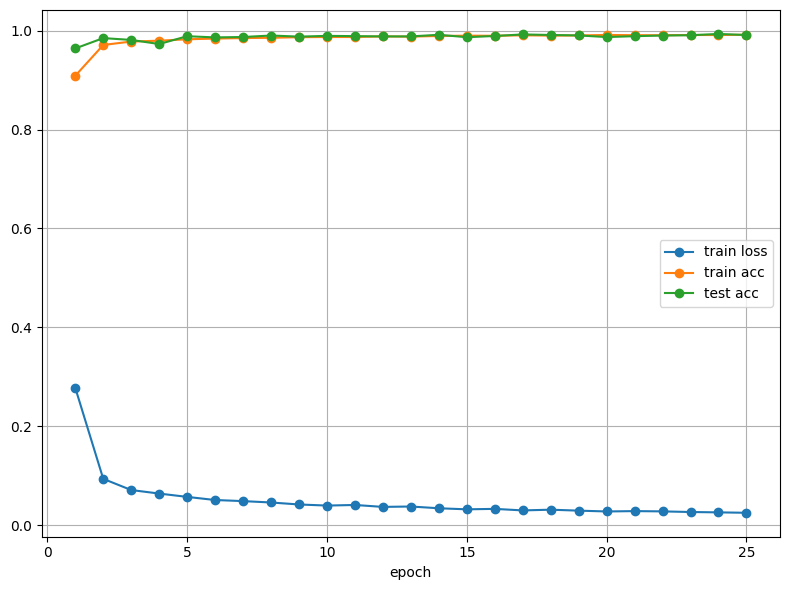

In [ ]:
# --- draw once at the very end ---

print("\n\n")
board = d2l.ProgressBoard()
board.x = 'epoch'
board.xlabel = 'epoch'
for e, v in zip(epochs_hist, train_loss_hist):
    board.draw(e, v, 'train loss')
for e, v in zip(epochs_hist, train_acc_hist):
    board.draw(e, v, 'train acc')
for e, v in zip(epochs_hist, test_acc_hist):
    board.draw(e, v, 'test acc')


## Summary

We have made significant progress in this chapter. We moved from the MLPs of the 1980s to the CNNs of the 1990s and early 2000s. The architectures proposed, e.g., in the form of LeNet-5 remain meaningful, even to this day. It is worth comparing the error rates on Fashion-MNIST achievable with LeNet-5 both to the very best possible with MLPs (:numref:`sec_mlp-implementation`) and those with significantly more advanced architectures such as ResNet (:numref:`sec_resnet`). LeNet is much more similar to the latter than to the former. One of the primary differences, as we shall see, is that greater amounts of computation enabled significantly more complex architectures.

A second difference is the relative ease with which we were able to implement LeNet. What used to be an engineering challenge worth months of C++ and assembly code, engineering to improve SN, an early Lisp-based deep learning tool :cite:`Bottou.Le-Cun.1988`, and finally experimentation with models can now be accomplished in minutes. It is this incredible productivity boost that has democratized deep learning model development tremendously. In the next chapter we will journey down this rabbit to hole to see where it takes us.

## Exercises

1. Let's modernize LeNet. Implement and test the following changes:
    1. Replace average pooling with max-pooling.
    1. Replace the softmax layer with ReLU.
1. Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs).
1. Try out the improved network on the original MNIST dataset.
1. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).
1. What happens to the activations when you feed significantly different images into the network (e.g., cats, cars, or even random noise)?


[Discussions](https://discuss.d2l.ai/t/74)
